In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


Algoritmo DC3 Para suffix Tree (no se usó)

In [117]:
#DC3 Complejidad O(n) sufix array

def skew_rec(x : list[int], asize : int) -> list[int]:
    "Recursive skew SA construction algorithm."

    SA12 = [i for i in range(len(x)) if i % 3 != 0]
    
    SA12 = radix3(x, asize, SA12)
    new_alpha = collect_alphabet(x, SA12)
    if len(new_alpha) < len(SA12):
        # Recursively sort SA12.
        # Construct the u string and compute its suffix array
        u = build_u(x, new_alpha)
        # For the recursion, remember that the real alphabet has
        # two sentinels, so + 2
        sa_u = skew_rec(u, len(new_alpha) + 2)
        # Then map u's suffix array back to a sorted SA12
        m = len(sa_u) // 2
        SA12 = [u_idx(i, m) for i in sa_u if i != m]

    # Special case if the last index is class 0. Then the
    # following class 1 isn't there, but we should treat it
    # as the smallest string in the class.
    SA3 = ([len(x) - 1] if len(x) % 3 == 1 else []) + \
          [i - 1 for i in SA12 if i % 3 == 1]
    SA3 = bucket_sort(x, asize, SA3)
    return merge(x, SA12, SA3)

def skew(x : str) -> list[int]:
    "Skew algorithm for a string."
    # The skew_rec() function wants a list of integers,
    # so we convert the string in the first call.
    # It is only because of the safe_idx() hack that we
    # need to convert the string; without it, we could work
    # with both str and list[int], but the sentinel we generate
    # is int, and we have to compare letters, so all letters must
    # then be int.
    # I am assuming that the alphabet size is 256 here, although
    # of course it might not be. It is a simplification instead of
    # remapping the string.
    return skew_rec([ord(y) for y in x], 256)


def safe_idx(x : list[int], i : int) -> int:
    "Hack to get zero if we index beyond the end."
    return 0 if i >= len(x) else x[i]

def symbcount(x : list[int], asize : int) -> list[int]:
    "Count how often we see each character in the alphabet."
    # This is what collections.Counter does, but we need the
    # alphabet to be sorted integers, so we do it manually.
    counts = [0] * asize
    for c in x:
        counts[c] += 1
    return counts

def cumsum(counts : list[int]) -> list[int]:
    "Compute the cumulative sum from the character count."
    res, acc = [0] * len(counts), 0
    for i, k in enumerate(counts):
        res[i] = acc
        acc += k
    return res

def bucket_sort(x : list[int], asize : int,
                idx : list[int], offset : int = 0) -> list[int]:
    "Sort indices in idx according to x[i + offset]."
    sort_symbs = [safe_idx(x, i + offset) for i in idx]
    counts = symbcount(sort_symbs, asize)
    buckets = cumsum(counts)
    out = [None] * len(idx)
    for i in idx:
        bucket = safe_idx(x, i + offset)
        out[buckets[bucket]] = i
        buckets[bucket] += 1
    return out

def radix3(x : list[int], asize : int, idx : list[int]) -> list[int]:
    "Sort indices in idx according to their first three letters in x."
    idx = bucket_sort(x, asize, idx, 2)
    idx = bucket_sort(x, asize, idx, 1)
    return bucket_sort(x, asize, idx)

TRIPLET = tuple[int,int,int]
TRIPLET_DICT = dict[TRIPLET,int]

def triplet(x : list[int], i : int) -> TRIPLET:
    "Extract the triplet (x[i],x[i+1],x[i+2])."
    return (safe_idx(x, i), safe_idx(x, i + 1), safe_idx(x, i + 2))

def collect_alphabet(x : list[int], idx : list[int]) -> TRIPLET_DICT:
    "Map the triplets starting at idx to a new alphabet."
    # I use 0 for the terminal sentinel and 1 for the 
    # separator, so I start the alphabet at 2, thus the + 2 later.
    # I'm using a dictionary for the alphabet, but you can build
    # it more efficiently by looking at the previous triplet in the
    # sorted SA12. It won't affect the asymptotic running time,
    # though.
    alpha = {}
    for i in idx:
        trip = triplet(x, i)
        if trip not in alpha:
            alpha[trip] = len(alpha) + 2 # +2 to reserve sentinels
    return alpha

def build_u(x : list[int], alpha : TRIPLET_DICT) -> list[int]:
    "Construct u string, using 1 as central sentinel."
    # By putting the i % 3 == 1 indices first, we know that the central
    # sentinel will always be at len(u) // 2.
    return [ *(alpha[triplet(x, i)] for i in range(1, len(x), 3)),
           1,
             *(alpha[triplet(x, i)] for i in range(2, len(x), 3)) ]



def u_idx(i : int, m : int) -> int:
    "Map indices in u back to indices in the original string."
    if i < m: return 1 + 3 * i
    else: return 2 + 3 * (i - m - 1)
    
    
def merge(x : list[int], SA12 : list[int], SA3 : list[int]) -> list[int]:
    "Merge the suffixes in sorted SA12 and SA3."
    # I'm using a dict here, but you can use a list with a little
    # arithmetic
    ISA = { SA12[i]: i for i in range(len(SA12)) }
    SA = []
    i, j = 0, 0
    while i < len(SA12) and j < len(SA3):
        if less(x, SA12[i], SA3[j], ISA):
            SA.append(SA12[i])
            i += 1
        else:
            SA.append(SA3[j])
            j += 1
    SA.extend(SA12[i:])
    SA.extend(SA3[j:])
    return SA

def less(x : list[int], i : int, j : int, ISA : dict[int,int]) -> bool:
    "Check if x[i:] < x[j:] using the inverse suffix array for SA12."
    a, b = safe_idx(x, i), safe_idx(x, j)
    if a < b: return True
    if a > b: return False
    if i % 3 != 0 and j % 3 != 0: return ISA[i] < ISA[j]
    return less(x, i + 1, j + 1, ISA)


Algoritmo de suffix Array ineficiente (no se usó)

In [118]:
def suffix_array(text):
    
    #Este no es eficiente complejidad O(n^2logn)
    
    suffixTemp=[]
    for i in range(0, len(text)):
        suffixTemp.append((text[i:], i))
    
    suffixTemp.sort()

    suffix_array = [suffix[1] for suffix in suffixTemp]
    
    return suffix_array


Algoritmo de lcs usando programación dinámica para que haya solapamiento

In [ ]:
#Se está asumiendo que en s1 se colocará el texto a comparar, y en s2 se usará el texto original 

def lcs_non_overlapping(s1, s2):
    
    len_s1, len_s2 = len(s1), len(s2)
    
    dp = [[0] * (len_s2 + 1) for _ in range(len_s1 + 1)]

    for i in range(1, len_s1 + 1):
        for j in range(1, len_s2 + 1):
            if s1[i - 1] == s2[j - 1]: #Comparación de letras
                dp[i][j] = dp[i - 1][j - 1] + 1 #se incrementa en uno desde la diagonal
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1]) #toma el valor mas alto de arriba o abajo

    i, j = len_s1, len_s2 # para recorrido inverso
    lcs_length_sum = 0 #almacenará la subsecuencia comun más larga
    lcs_sequence = [] # almacenará la subsecuencia comun más larga
    lcs_index = [] #almacenará los indices del texto 
    
    while i > 0 and j > 0:
        
        if s1[i - 1] == s2[j - 1]:# comparacion de letras
            lcs_index.append(i - 1)
            lcs_sequence.append(s1[i - 1])
            match_length = dp[i][j] - dp[i - 1][j - 1]
            lcs_length_sum += match_length
            #retroceso diagonal
            i -= 1
            j -= 1
        elif dp[i - 1][j] >= dp[i][j - 1]: #izquierda es mayor a arriba
            i -= 1
        else:
            j -= 1
    
    lcs_sequence.reverse()
    lcs_index.reverse()

    return lcs_length_sum, lcs_sequence, lcs_index


En esta parte se usa la función lcs_non_overlappin, que encuentra la subsecuencia común más larga (LCS) entre dos cadenas, s1 y s2, aplicando programación dinámica. Primero, construye una matriz dp que almacena la longitud de las subsecuencias comunes posibles para cada par de caracteres entre ambas cadenas. Una vez completada esta matriz, un recorrido inverso permite reconstruir la LCS, guardando los caracteres de esta subsecuencia y sus posiciones en s1. La función retorna tres elementos: la longitud total de la subsecuencia común (lcs_length_sum), la secuencia de caracteres que componen el LCS (lcs_sequence) y los índices de estos caracteres en s1 (lcs_index), lo que permite identificar las coincidencias exactas en el texto.

Algoritmo para calcular el porcentaje de similitud

In [ ]:
#Se asume que en text1 se colocará el texto a comparar y en text2 se colocará el texto original
def similarity_percentage(text1, text2):
    lcs_length_sum, lcs_sequence, lcs_index = lcs_non_overlapping(text1, text2)
    max_len = max(len(text1), len(text2))
    similarity = (lcs_length_sum / max_len)
    # lcs_sequence = ''.join(lcs_sequence)
    return similarity, lcs_sequence, lcs_index


La función similarity_percentage calcula la similitud entre text1 y text2. Usa lcs_non_overlapping para obtener la longitud de la subsecuencia común más larga (lcs_length_sum), la secuencia (lcs_sequence), y sus posiciones en text1 (lcs_index). Luego, divide esta longitud entre la del texto más largo para calcular la similitud (similarity). Finalmente, devuelve el porcentaje de similitud, la secuencia y los índices en text1.

Función para pasar las clases a códigos numericos (solo se usa para comparar)

In [ ]:
def class_to_numbers(csv):
    df=pd.read_csv(csv)
    df['Class']=df['Category'].map({'non':0,'heavy':1,'light':2,'cut':3,'orig':-1})
    return df


La función class_to_numbers convierte las clases en valores numéricos. Lee un archivo CSV en un DataFrame de pandas y mapea la columna Category a números: 'non' a 0, 'heavy' a 1, 'light' a 2, 'cut' a 3, y 'orig' a -1. Devuelve el DataFrame con la nueva columna Class.

Lectura de información de los txt

In [123]:
file_info=pd.read_csv('data/file_information.csv')
file_info

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non
...,...,...,...
95,orig_taska.txt,a,orig
96,orig_taskb.txt,b,orig
97,orig_taskc.txt,c,orig
98,orig_taskd.txt,d,orig


El código file_info=pd.read_csv('data/file_information.csv') carga un archivo CSV en un DataFrame de pandas llamado file_info. Al ejecutar file_info, se muestra su contenido en este formato.

Filtro de distribución de archivo por categoría

In [124]:
pd.crosstab(file_info['Category'],file_info['Task'],margins=True)

Task,a,b,c,d,e,All
Category,,,,,,
cut,4,3,3,4,5,19
heavy,3,4,5,4,3,19
light,3,3,4,5,4,19
non,9,9,7,6,7,38
orig,1,1,1,1,1,5
All,20,20,20,20,20,100


Esto genera una tabla de contingencia que muestra la relación entre Category y Task en file_info

Se colocan la classe en codigo numérico por categoría

In [125]:
df=class_to_numbers('data/file_information.csv')
df

,File,Task,Category,Class
0,g0pA_taska.txt,a,non,0
1,g0pA_taskb.txt,b,cut,3
2,g0pA_taskc.txt,c,light,2
3,g0pA_taskd.txt,d,heavy,1
4,g0pA_taske.txt,e,non,0
...,...,...,...,...
95,orig_taska.txt,a,orig,-1
96,orig_taskb.txt,b,orig,-1
97,orig_taskc.txt,c,orig,-1
98,orig_taskd.txt,d,orig,-1


Primero carga el CSV file_information.csv, convierte las categorías en valores numéricos y almacena el resultado en df. Finalmente se muestra su contenido.

Lectura de archivos en minúsculas y asignación en DF

In [126]:
texts = []
for i in df['File']:
    with open('data/'+i,'r',encoding='UTF-8',errors='ignore') as f:
        line=f.read()
        line=re.sub(r'[^\w\s]', ' ',line.lower())
        line=line.replace('\n',' ')
        line=line.replace('\t',' ')
        line=line.replace('   ',' ')
        line=line.replace('  ',' ')
        texts.append(line)
        f.close()
df['Text']=texts
del(texts)
df



,File,Task,Category,Class,Text
0,g0pA_taska.txt,a,non,0,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,cut,3,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,light,2,the vector space model also called term vector...
3,g0pA_taskd.txt,d,heavy,1,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,non,0,dynamic programming is an algorithm design tec...
...,...,...,...,...,...
95,orig_taska.txt,a,orig,-1,in object oriented programming inheritance is ...
96,orig_taskb.txt,b,orig,-1,pagerank is a link analysis algorithm used by ...
97,orig_taskc.txt,c,orig,-1,vector space model or term vector model is an ...
98,orig_taskd.txt,d,orig,-1,in probability theory bayes theorem often call...


El código procesa archivos en la columna File de df, limpiando su contenido (minúsculas, eliminación de caracteres especiales y espacios) y lo añade como una nueva columna. Luego, muestra el DataFrame actualizado.

Generación de columna de SuffixArray

In [127]:
df['SuffixArray'] = df['Text'].apply(skew)
df

,File,Task,Category,Class,Text,SuffixArray
0,g0pA_taska.txt,a,non,0,inheritance is a basic concept of object orien...,"[1341, 14, 967, 508, 112, 281, 1052, 165, 575,..."
1,g0pA_taskb.txt,b,cut,3,pagerank is a link analysis algorithm used by ...,"[1212, 300, 302, 133, 11, 466, 275, 92, 525, 3..."
2,g0pA_taskc.txt,c,light,2,the vector space model also called term vector...,"[1360, 264, 1234, 1106, 336, 355, 293, 1034, 5..."
3,g0pA_taskd.txt,d,heavy,1,bayes theorem was names after rev thomas bayes...,"[1208, 781, 654, 855, 53, 418, 639, 825, 968, ..."
4,g0pA_taske.txt,e,non,0,dynamic programming is an algorithm design tec...,"[1225, 818, 831, 479, 527, 574, 661, 952, 840,..."
...,...,...,...,...,...,...
95,orig_taska.txt,a,orig,-1,in object oriented programming inheritance is ...,"[1921, 194, 745, 1850, 1534, 1308, 1218, 1038,..."
96,orig_taskb.txt,b,orig,-1,pagerank is a link analysis algorithm used by ...,"[3024, 886, 1859, 752, 1861, 839, 573, 848, 57..."
97,orig_taskc.txt,c,orig,-1,vector space model or term vector model is an ...,"[1459, 979, 1111, 1221, 980, 1112, 1222, 1362,..."
98,orig_taskd.txt,d,orig,-1,in probability theory bayes theorem often call...,"[1822, 1181, 1395, 1252, 1558, 1609, 412, 1607..."


El código aplica la función skew a la columna Text de df y almacena los resultados en una nueva columna llamada SuffixArray, luego muestra el DataFrame.

Clasificación de textos originales

In [128]:
orig_texts = df[df['Category'] == 'orig'].set_index('Task')['Text'].to_dict()
orig_texts

{'a': 'in object oriented programming inheritance is a way to form new classes instances of which are called objects using classes that have already been defined the inheritance concept was invented in 1967 for simula the new classes known as derived classes take over or inherit attributes and behavior of the pre existing classes which are referred to as base classes or ancestor classes it is intended to help reuse existing code with little or no modification inheritance provides the support for representation by categorization in computer languages categorization is a powerful mechanism number of information processing crucial to human learning by means of generalization what is known about specific entities is applied to a wider group given a belongs relation can be established and cognitive economy less information needs to be stored about each specific entity only its particularities inheritance is also sometimes called generalization because the is a relationships represent a hier

Aquí el código crea un diccionario orig_texts que mapea las task originales a su texto, filtrando df por la categoría 'orig'.

In [ ]:
"Aplicación y filtro de algoritmo lcs (se obtiene subcadena más larga, indices en el texto original y porcentajes de similitud)"

In [ ]:

similarity_scores = []
subsecuences = []
indexes = []

for index, row in df.iterrows():
    if row['Category'] == 'orig':
        # Si es un texto original, no calcula similitud
        similarity_scores.append(None)
        subsecuences.append(None)
        indexes.append(None)

    else:
        # Obtiene el texto original correspondiente a la misma tarea
        orig_text = orig_texts.get(row['Task'])
        if orig_text:
            # Calcula el porcentaje de similitud utilizando la función similarity_percentage
            similarity, subsecuence, index = similarity_percentage(row['Text'], orig_text) 
            similarity = similarity
            similarity_scores.append(similarity)
            subsecuences.append(subsecuence)
            indexes.append(index)

        else:
            similarity_scores.append(None)
            subsecuences.append(None)
            indexes.append(None)

df['Similarity_LCS'] = similarity_scores
df['Sub_Secuences'] = subsecuences
df['Indexes'] = indexes

df[['File', 'Category', 'Class', 'Similarity_LCS', 'Sub_Secuences', 'Indexes']]


,File,Category,Class,Similarity_LCS,sub_Secuences,indexes
0,g0pA_taska.txt,non,0,0.388137,"[i, n, , o, b, j, e, c, t, , o, r, i, e, n, ...","[20, 25, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4..."
1,g0pA_taskb.txt,cut,3,0.350744,"[p, a, g, e, r, a, n, k, , i, s, , a, , l, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,g0pA_taskc.txt,light,2,0.834932,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
3,g0pA_taskd.txt,heavy,1,0.395502,"[b, a, y, , t, h, e, o, r, , a, e, s, , t, ...","[0, 1, 2, 5, 6, 7, 8, 9, 10, 13, 15, 21, 22, 2..."
4,g0pA_taske.txt,non,0,0.275467,"[d, y, n, a, m, i, c, , p, r, o, g, r, a, m, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
...,...,...,...,...,...,...
95,orig_taska.txt,orig,-1,NaN,None,None
96,orig_taskb.txt,orig,-1,NaN,None,None
97,orig_taskc.txt,orig,-1,NaN,None,None
98,orig_taskd.txt,orig,-1,NaN,None,None


El código calcula la similitud entre textos no originales y sus correspondientes originales, almacenando los resultados en nuevas columnas (Similarity_LCS, Sub_Secuences, Indexes) en df

Sorteo de mayor a menor por porcentaje de similitud

In [ ]:
df_sorted = df.sort_values(by='Similarity_LCS', ascending=False)
df_sorted[['File', 'Category', 'Class', 'Similarity_LCS', 'Sub_Secuences', 'Indexes']]

,File,Category,Class,Similarity_LCS,sub_Secuences,indexes
63,g3pA_taskd.txt,cut,3,0.987383,"[i, n, , p, r, o, b, a, b, i, l, i, t, y, , ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
20,g0pE_taska.txt,light,2,0.938085,"[i, n, , o, b, j, e, c, t, , o, r, i, e, n, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
83,g4pC_taskd.txt,heavy,1,0.888645,"[i, n, , p, r, o, b, a, b, i, l, i, t, y, , ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
42,g2pA_taskc.txt,light,2,0.887995,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
2,g0pA_taskc.txt,light,2,0.834932,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
...,...,...,...,...,...,...
95,orig_taska.txt,orig,-1,NaN,None,None
96,orig_taskb.txt,orig,-1,NaN,None,None
97,orig_taskc.txt,orig,-1,NaN,None,None
98,orig_taskd.txt,orig,-1,NaN,None,None


El código ordena df por Similarity_LCS en orden descendente y muestra las columnas seleccionadas.

Visualización de solo los 10 más altos

In [ ]:
df_sorted = df.sort_values(by='Similarity_LCS', ascending=False)
df_sorted[['File', 'Category', 'Class', 'Similarity_LCS', 'Sub_Secuences', 'Indexes']].head(10)

,File,Category,Class,Similarity_LCS,sub_Secuences,indexes
63,g3pA_taskd.txt,cut,3,0.987383,"[i, n, , p, r, o, b, a, b, i, l, i, t, y, , ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
20,g0pE_taska.txt,light,2,0.938085,"[i, n, , o, b, j, e, c, t, , o, r, i, e, n, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
83,g4pC_taskd.txt,heavy,1,0.888645,"[i, n, , p, r, o, b, a, b, i, l, i, t, y, , ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
42,g2pA_taskc.txt,light,2,0.887995,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
2,g0pA_taskc.txt,light,2,0.834932,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
80,g4pC_taska.txt,cut,3,0.823621,"[i, n, , o, b, j, e, c, t, , o, r, i, e, n, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
48,g2pB_taskd.txt,light,2,0.822820,"[i, n, , p, r, o, b, a, b, i, l, i, t, y, , ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
55,g2pE_taska.txt,heavy,1,0.682788,"[i, n, , o, b, j, e, c, t, , o, r, i, e, n, ...","[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4..."
77,g4pB_taskc.txt,heavy,1,0.668493,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
7,g0pB_taskc.txt,cut,3,0.663451,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


El código ordena df por Similarity_LCS en orden descendente y muestra las primeras 10 filas de las columnas 

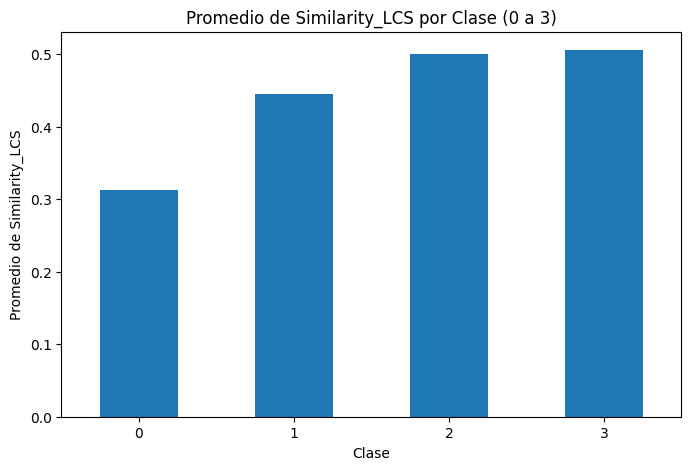

In [141]:
df_filtered = df[(df['Class'] >= 0) & (df['Class'] <= 3)]
avg_similarity = df_filtered.groupby('Class')['Similarity_LCS'].mean()

plt.figure(figsize=(8, 5))
avg_similarity.plot(kind='bar')
plt.title('Promedio de Similarity_LCS por Clase (0 a 3)')
plt.xlabel('Clase')
plt.ylabel('Promedio de Similarity_LCS')
plt.xticks(rotation=0)
plt.show()

El código filtra df por clases de 0 a 3, calcula el promedio de Similarity_LCS por clase y genera un gráfico de barras.

In [133]:
df

,File,Task,Category,Class,Text,SuffixArray,Similarity_LCS,sub_Secuences,indexes
0,g0pA_taska.txt,a,non,0,inheritance is a basic concept of object orien...,"[1341, 14, 967, 508, 112, 281, 1052, 165, 575,...",0.388137,"[i, n, , o, b, j, e, c, t, , o, r, i, e, n, ...","[20, 25, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4..."
1,g0pA_taskb.txt,b,cut,3,pagerank is a link analysis algorithm used by ...,"[1212, 300, 302, 133, 11, 466, 275, 92, 525, 3...",0.350744,"[p, a, g, e, r, a, n, k, , i, s, , a, , l, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,g0pA_taskc.txt,c,light,2,the vector space model also called term vector...,"[1360, 264, 1234, 1106, 336, 355, 293, 1034, 5...",0.834932,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
3,g0pA_taskd.txt,d,heavy,1,bayes theorem was names after rev thomas bayes...,"[1208, 781, 654, 855, 53, 418, 639, 825, 968, ...",0.395502,"[b, a, y, , t, h, e, o, r, , a, e, s, , t, ...","[0, 1, 2, 5, 6, 7, 8, 9, 10, 13, 15, 21, 22, 2..."
4,g0pA_taske.txt,e,non,0,dynamic programming is an algorithm design tec...,"[1225, 818, 831, 479, 527, 574, 661, 952, 840,...",0.275467,"[d, y, n, a, m, i, c, , p, r, o, g, r, a, m, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
...,...,...,...,...,...,...,...,...,...
95,orig_taska.txt,a,orig,-1,in object oriented programming inheritance is ...,"[1921, 194, 745, 1850, 1534, 1308, 1218, 1038,...",NaN,None,None
96,orig_taskb.txt,b,orig,-1,pagerank is a link analysis algorithm used by ...,"[3024, 886, 1859, 752, 1861, 839, 573, 848, 57...",NaN,None,None
97,orig_taskc.txt,c,orig,-1,vector space model or term vector model is an ...,"[1459, 979, 1111, 1221, 980, 1112, 1222, 1362,...",NaN,None,None
98,orig_taskd.txt,d,orig,-1,in probability theory bayes theorem often call...,"[1822, 1181, 1395, 1252, 1558, 1609, 412, 1607...",NaN,None,None


In [134]:
ten_most_common = df_sorted.head(10)

In [135]:
ten_most_common[['Text', 'sub_Secuences', 'indexes']]

,Text,sub_Secuences,indexes
63,in probability theory bayes theorem often call...,"[i, n, , p, r, o, b, a, b, i, l, i, t, y, , ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
20,in object oriented programming inheritance is ...,"[i, n, , o, b, j, e, c, t, , o, r, i, e, n, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
83,in probability theory bayes theorem relates th...,"[i, n, , p, r, o, b, a, b, i, l, i, t, y, , ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
42,a vector space model or term vector model is a...,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
2,the vector space model also called term vector...,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
80,in object oriented programming inheritance is ...,"[i, n, , o, b, j, e, c, t, , o, r, i, e, n, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
48,in probability theory bayes theorem also call...,"[i, n, , p, r, o, b, a, b, i, l, i, t, y, , ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
55,when we talk about inheritance in object orien...,"[i, n, , o, b, j, e, c, t, , o, r, i, e, n, ...","[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4..."
77,the vector space model or term vector model is...,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
7,vector space model is an algebraic model for r...,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


El código muestra las columnas Text, Sub_Secuences e Indexes del DataFrame ten_most_common.

In [136]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [ ]:
"Define la clase color con constantes para aplicar colores y estilos de texto en la terminal(ANSI)"

In [137]:
string2 = ["J", "J", "J", "J", "J", "J", "J", "J", ]
string2[5] = color.CYAN + string2[5] + color.END
print(string2)
string2 = ''.join(string2)

print(string2)

['J', 'J', 'J', 'J', 'J', '\x1bJ\x1b', 'J', 'J']
JJJJJJJJ


Para prueba funcional se aplica color cian al sexto elemento, imprime la lista y luego une los elementos en una cadena, mostrando el color en la impresión final.

In [138]:
string = ["a", "a", "a", "b", "a", "a", "b", "a", "a", "a", "b", "a", "a", "b"]

index = []

for i in range(len(string)):
    if string[i] == "b":
        index.append(i)
index


[3, 6, 10, 13]

In [139]:
string = ["a", "a", "a", "b", "a", "a", "b", "a", "a", "a", "b", "a", "a", "b"]


pointer = 0
for j in range(len(string)):
    if j == index[pointer]: 
        string[j] = color.CYAN + string[j] + color.END
        pointer += 1

print(string)    
string = ''.join(string)
print(string)

        

['a', 'a', 'a', '\x1bb\x1b', 'a', 'a', '\x1bb\x1b', 'a', 'a', 'a', '\x1bb\x1b', 'a', 'a', '\x1bb\x1b']
aaabaabaaabaab


Aquí aplicamos color cian a las letras "b" en la lista string según sus índices en index, imprime la lista y luego la convierte en una cadena(otra prueba)

In [152]:
def print_comparision_text(textList, textIndex):
    textList = list(textList)
    pointer = 0
    for j in range(len(textList)):
        if j == textIndex[pointer]: 
            textList[j] = color.CYAN + textList[j] + color.END
            pointer += 1
    textList =''.join(textList)
    
    return textList

La función print_comparision_text aplica color cian a los elementos de textList cuyos índices están en textIndex, convierte la lista en una cadena y devuelve el resultado

In [ ]:
comparison_Matrix_df = ten_most_common[['Text', 'sub_Secuences', 'indexes']]
comparison_Matrix_df


,Text,sub_Secuences,indexes
63,in probability theory bayes theorem often call...,"[i, n, , p, r, o, b, a, b, i, l, i, t, y, , ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
20,in object oriented programming inheritance is ...,"[i, n, , o, b, j, e, c, t, , o, r, i, e, n, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
83,in probability theory bayes theorem relates th...,"[i, n, , p, r, o, b, a, b, i, l, i, t, y, , ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
42,a vector space model or term vector model is a...,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
2,the vector space model also called term vector...,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
80,in object oriented programming inheritance is ...,"[i, n, , o, b, j, e, c, t, , o, r, i, e, n, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
48,in probability theory bayes theorem also call...,"[i, n, , p, r, o, b, a, b, i, l, i, t, y, , ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
55,when we talk about inheritance in object orien...,"[i, n, , o, b, j, e, c, t, , o, r, i, e, n, ...","[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4..."
77,the vector space model or term vector model is...,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
7,vector space model is an algebraic model for r...,"[v, e, c, t, o, r, , s, p, a, c, e, , m, o, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


nuevo DataFrame

In [165]:
for i in range(0, 9):
    text = comparison_Matrix_df.iloc[i]['Text']
    index = comparison_Matrix_df.iloc[i]['indexes']
    print()
    print(f"Plagio en texto : {i+1}")
    print()
    print(print_comparision_text(text, index))
    print()



Plagio en texto : 1

in probability theory bayes theorem often called bayes law after rev thomas bayes relates the conditional and marginal probabilities of two random events it is often used to compute posterior probabilities given observations for example a patient may be observed to have certain symptoms bayes theorem can be used to compute the probability that a proposed diagnosis is correct given that observation as a formal theorem bayes theorem is valid in all common interpretations of probability however it plays a central role in the debate around the foundations of statistics frequentist and bayesian interpretations disagree about the ways in which probabilities should be assigned in applications frequentists assign probabilities to random events according to their frequencies of occurrence or to subsets of populations as proportions of the whole while bayesians describe probabilities in terms of beliefs and degrees of uncertainty the articles on bayesian probability and fre

En esta parte recorre las primeras 9 filas de comparison_Matrix_df, extrayendo el texto y los índices de plagio, e imprime el texto resaltando las secciones similares usando la función print_comparision_text

Explicación general del código:

El código implementa una lógica para calcular el porcentaje de plagio entre un texto y su original. Primero, encuentra la subcadena más larga en común entre ambos textos utilizando el algoritmo LCS (Longest Common Substring). Este algoritmo permite obtener la subcadena más extensa compartida, su longitud, y las posiciones específicas de cada letra dentro de esta en el texto original.

Luego, para obtener el porcentaje de plagio, divide la longitud de esta subcadena entre la longitud total del texto original. Este cociente representa el porcentaje de similitud o plagio.

Finalmente, para presentar el resultado visualmente, usa las posiciones obtenidas para resaltar en el texto original cada letra que forma parte de la subcadena coincidente, aplicando un color a esas posiciones específicas. Esto facilita la identificación visual de las secciones plagiadas en el texto.

Reflexiones finales

Alvaro Alberto Cruz Jiménez - A01737453

La actividad nos retó a utilizar métodos eficientes y algoritmos aplicados a cadenas de texto para cumplir con el reto. Viendo la importancia de analizar e implementar algoritmos de eficiencia decente cuando se automatizan tareas largas. Y de igual forma notamos que no se necesitan de procesos complejos como entrenamiento de redes neuronales para completar los retos como los ponía el repositorio y el artículo propuesto, un método de identificación usando algoritmos de implementación más rápida es capaz de arrojar resultados similares en mucho menos tiempo y con mucha mayor velocidad.


Dylan Martinez Alonzo – A01736968

El reto es una vista interesante hacia el uso de distintas estructuras de datos y algoritmos para hacer más eficientes tareas que de otra manera serian mucho más complejas, en este reto especifico tuvimos que comparar una cantidad pequeña de información, pero es claro como todas estas técnicas escalan muy rápido para llegar a comparar millones de textos, lo cual es muy importante hoy en día, en especial con la popularización de la IA.


Ana Luisa Cruz Flores - A01735115

Este proyecto me gustó bastante, ya que me enseñó cómo, a través de las estructuras y algoritmos aprendidos durante el semestre, podemos desarrollar programas útiles para el día a día. Esto me resultó emocionante, ya que fue una manera práctica de comprender cómo funcionan estos algoritmos y su utilidad en contextos reales. Además, fue una excelente oportunidad para repasar conceptos clave, especialmente porque tuvimos la flexibilidad de elegir nuestra metodología. Esto nos permitió darnos cuenta de que existen diversas formas de abordar y resolver problemas, y nos ayudó a reforzar qué tipo de estructura es más adecuada para optimizar el código según los requerimientos específicos.